# linear regression
You are hired by a company Gem Stones co ltd, which is a cubic zirconia manufacturer. You are provided with the dataset containing the prices and other attributes of almost 27,000 cubic zirconia (which is an inexpensive diamond alternative with many of the same qualities as a diamond). The company is earning different profits on different prize slots. You have to help the company in predicting the price for the stone on the bases of the details given in the dataset so it can distinguish between higher profitable stones and lower profitable stones so as to have better profit share. Also, provide them with the best 5 attributes that are most important.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings 
warnings.filterwarnings('ignore')
import math
import statistics as st
import scipy.stats as stats
from scipy.stats import iqr
from scipy.stats import zscore
import statsmodels.formula.api as smf
from sklearn.preprocessing import scale
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from statsmodels.stats.outliers_influence import variance_inflation_factor 

# Read dataset

In [2]:
data= pd.read_csv('cubic_zirconia.csv')

In [3]:
print('The dataset has the shape of',data.shape)

The dataset has the shape of (26967, 11)


In [4]:
data.head()

,Unnamed: 0,carat,cut,color,clarity,depth,table,x,y,z,price
0,1,0.30,Ideal,E,SI1,62.1,58.0,4.27,4.29,2.66,499
1,2,0.33,Premium,G,IF,60.8,58.0,4.42,4.46,2.70,984
2,3,0.90,Very Good,E,VVS2,62.2,60.0,6.04,6.12,3.78,6289
3,4,0.42,Ideal,F,VS1,61.6,56.0,4.82,4.80,2.96,1082
4,5,0.31,Ideal,F,VVS1,60.4,59.0,4.35,4.43,2.65,779


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26967 entries, 0 to 26966
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  26967 non-null  int64  
 1   carat       26967 non-null  float64
 2   cut         26967 non-null  object 
 3   color       26967 non-null  object 
 4   clarity     26967 non-null  object 
 5   depth       26270 non-null  float64
 6   table       26967 non-null  float64
 7   x           26967 non-null  float64
 8   y           26967 non-null  float64
 9   z           26967 non-null  float64
 10  price       26967 non-null  int64  
dtypes: float64(6), int64(2), object(3)
memory usage: 2.3+ MB


The data has some missing values in the depth column we need to do further analysis in future about this.

In [6]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,26967.0,13484.000000,7784.846691,1.0,6742.50,13484.00,20225.50,26967.00
carat,26967.0,0.798375,0.477745,0.2,0.40,0.70,1.05,4.50
depth,26270.0,61.745147,1.412860,50.8,61.00,61.80,62.50,73.60
table,26967.0,57.456080,2.232068,49.0,56.00,57.00,59.00,79.00
x,26967.0,5.729854,1.128516,0.0,4.71,5.69,6.55,10.23
y,26967.0,5.733569,1.166058,0.0,4.71,5.71,6.54,58.90
z,26967.0,3.538057,0.720624,0.0,2.90,3.52,4.04,31.80
price,26967.0,3939.518115,4024.864666,326.0,945.00,2375.00,5360.00,18818.00


In [7]:
data = data.drop('Unnamed: 0',axis = 1)

In [8]:
def zero_count(_series):
    counter=0
    for val in _series:
        if val==0:
            counter+=1
    return counter 

def negative_count(_series):
    counter=0
    for val in _series:
        if val < 0:
            counter+=1
    return counter 

def percent_outlier(_series):
    counter = 0
    lb = np.percentile(_series,.25) - (1.5*iqr(_series))
    ub = np.percentile(_series,.75) + (1.5*iqr(_series))
    for val in _series:
        if val>ub or val<lb: 
            counter=counter+1
        else : pass
    return 100*counter/len(_series)

stat_list = ['TOTAL RECORDS',
 'NULL COUNT',
 'ZERO COUNT',
 'NEGATIVE COUNT',
 'MIN',
 'MAX',
 'RANGE',
 'MEAN',
 'MEDIAN',
 'MODE',
 'VARIANCE',
 'STD DEV',
 'Q1',
 'Q3',
 'IQR',
 'SKEWNESS',
 'KURTOSIS']

def stat_function(_series):
    return [round(val,2) for val in 
          [len(_series),
           _series.isna().sum(),
           zero_count(_series),
           negative_count(_series),
           min(_series),
           max(_series),
           max(_series)-min(_series),
           _series.mean(),
           np.percentile(_series,.5),
           _series.mode()[0],
           st.variance(_series),
           st.stdev(_series),
           np.percentile(_series,.25),
           np.percentile(_series,.75),
           iqr(_series),
           stats.skew(_series),
           stats.kurtosis(_series)]
          ]

def stat_df(data, feature_list):
    stat_dictionary = {}
    for x in feature_list:
        stat_dictionary[x] = stat_function(data[x])
    return pd.DataFrame(stat_dictionary, index = stat_list).T

# Finding % Outliers in our Data
def outlier_percentage_df(data, features_list):
    dict_outlier = {}
    for x in features_list:
        dict_outlier[x]=round(percent_outlier(data[x]),2)
    return pd.DataFrame(dict_outlier, index=["% OUTLIERS"]).T.sort_values("% OUTLIERS", ascending=False)

In [9]:
categorical_features=[]
numerical_features=[]
for i in data.columns:
    if data[i].dtype=="object":
        categorical_features.append(i)
    else:
        numerical_features.append(i)
print(categorical_features) 
print(numerical_features)


['cut', 'color', 'clarity']
['carat', 'depth', 'table', 'x', 'y', 'z', 'price']


In [10]:
stat_df(data, numerical_features).T

,carat,depth,table,x,y,z,price
TOTAL RECORDS,26967.00,26967.00,26967.00,26967.00,26967.00,26967.00,26967.00
NULL COUNT,0.00,697.00,0.00,0.00,0.00,0.00,0.00
ZERO COUNT,0.00,0.00,0.00,3.00,3.00,9.00,0.00
NEGATIVE COUNT,0.00,0.00,0.00,0.00,0.00,0.00,0.00
MIN,0.20,50.80,49.00,0.00,0.00,0.00,326.00
MAX,4.50,73.60,79.00,10.23,58.90,31.80,18818.00
RANGE,4.30,22.80,30.00,10.23,58.90,31.80,18492.00
MEAN,0.80,61.75,57.46,5.73,5.73,3.54,3939.52
MEDIAN,0.23,NaN,53.00,3.96,3.99,2.44,399.83
MODE,0.30,62.00,56.00,4.38,4.35,2.69,544.00


x ,y, z are represent the dimentions in the column. so min values are shown here is 0. these are fault values because we know that dimentionless and 2D dimention diamonds are not exits.

Kurthosis the x column only has the neagtive high frequency in the dataset.

<AxesSubplot:>

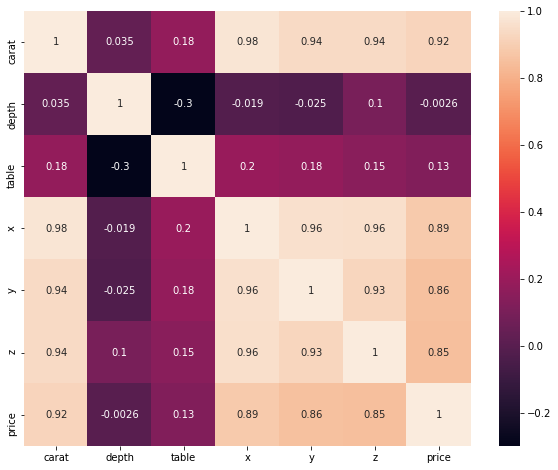

In [12]:
corr_df = data[numerical_features].corr()
plt.figure(figsize = (10,8))
sns.heatmap(corr_df,annot = True)

In [13]:
corr_df[corr_df>0.70]

,carat,depth,table,x,y,z,price
carat,1.000000,NaN,NaN,0.976368,0.941071,0.940640,0.922416
depth,NaN,1.0,NaN,NaN,NaN,NaN,NaN
table,NaN,NaN,1.0,NaN,NaN,NaN,NaN
x,0.976368,NaN,NaN,1.000000,0.962715,0.956606,0.886247
y,0.941071,NaN,NaN,0.962715,1.000000,0.928923,0.856243
z,0.940640,NaN,NaN,0.956606,0.928923,1.000000,0.850536
price,0.922416,NaN,NaN,0.886247,0.856243,0.850536,1.000000


# High correlation :
    1. x correlated with y 
    2. z correlated with x
    3. Price column has highly correlated with x,y,z,Price columns.

In [14]:
data.columns

Index(['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'x', 'y', 'z',
       'price'],
      dtype='object')

# Duplicate values

In [15]:
dup = data.duplicated().sum()
print('The Duplicate Rows are',dup)

The Duplicate Rows are 34


In [16]:
dups = data.drop_duplicates(inplace = True)
print('The Duplicate Rows are',dups)

The Duplicate Rows are None


# Missing values

In [17]:
data.isnull().sum()

carat        0
cut          0
color        0
clarity      0
depth      697
table        0
x            0
y            0
z            0
price        0
dtype: int64

Depth column only has 697 missing value in the dataset

In [19]:
data.median()

carat       0.70
depth      61.80
table      57.00
x           5.69
y           5.70
z           3.52
price    2375.00
dtype: float64

Replacing the median values with the missing values.

In [21]:
data = data.fillna(data.median())

In [22]:
data.isnull().sum()

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
x          0
y          0
z          0
price      0
dtype: int64

# Boxplot

In [23]:
outlier_percentage_df(data,numerical_features)

,% OUTLIERS
depth,91.84
table,44.93
x,19.02
z,18.83
y,18.75
price,17.20
carat,16.32


All the column has outliers and Depth column Has the high percentage of outliers

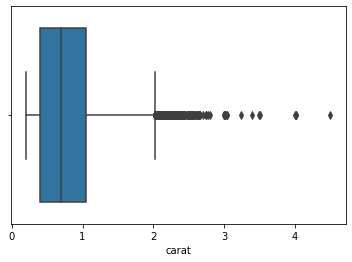

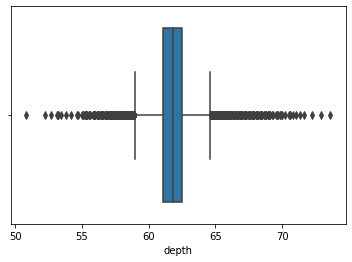

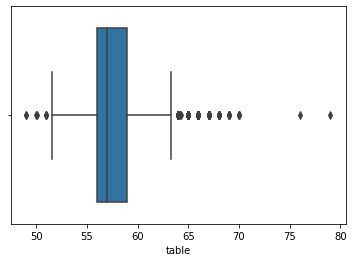

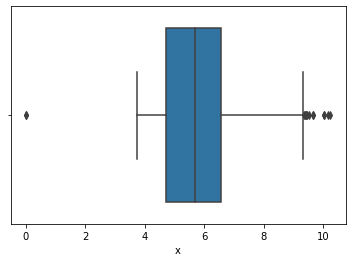

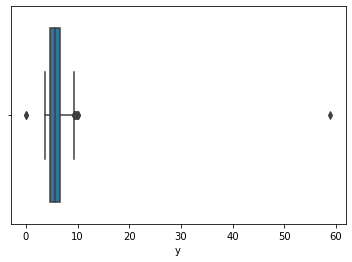

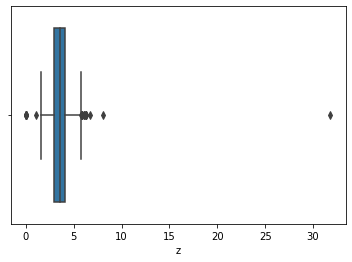

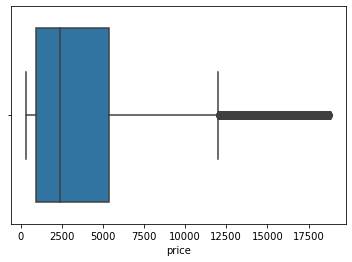

In [24]:
for i in numerical_features:
    sns.boxplot(data[i],whis = 1.5)
    plt.show()

# Outlier treatment

In [25]:
def remove_outlier(col):
    sorted(col)
    Q1,Q3=np.percentile(col,[25,75])
    IQR=Q3-Q1
    lower_range= Q1-(1.5 * IQR)
    upper_range= Q3+(1.5 * IQR)
    return lower_range, upper_range   

In [26]:
for column in numerical_features:
    lr,ur=remove_outlier(data[column])
    data[column]=np.where(data[column]>ur,ur,data[column])
    data[column]=np.where(data[column]<lr,lr,data[column])

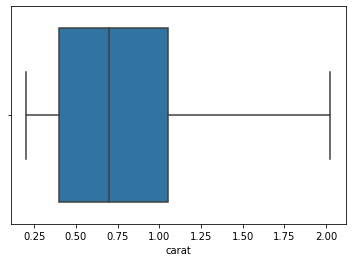

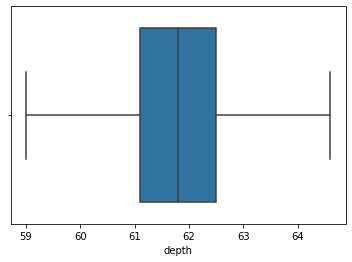

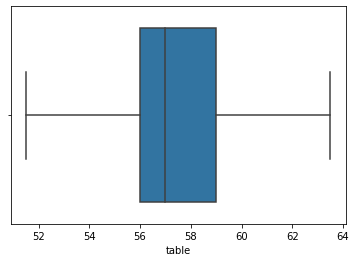

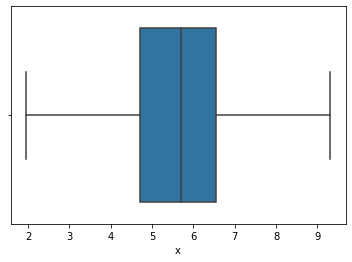

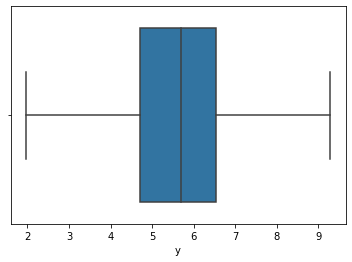

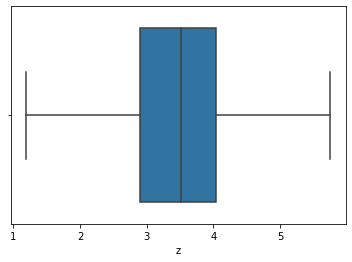

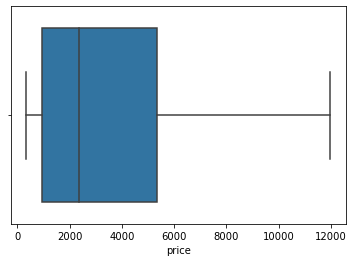

In [27]:
for i in numerical_features:
    sns.boxplot(data[i],whis = 1.5)
    plt.show()

# Histogram

array([[<AxesSubplot:title={'center':'carat'}>,
        <AxesSubplot:title={'center':'depth'}>,
        <AxesSubplot:title={'center':'table'}>],
       [<AxesSubplot:title={'center':'x'}>,
        <AxesSubplot:title={'center':'y'}>,
        <AxesSubplot:title={'center':'z'}>],
       [<AxesSubplot:title={'center':'price'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

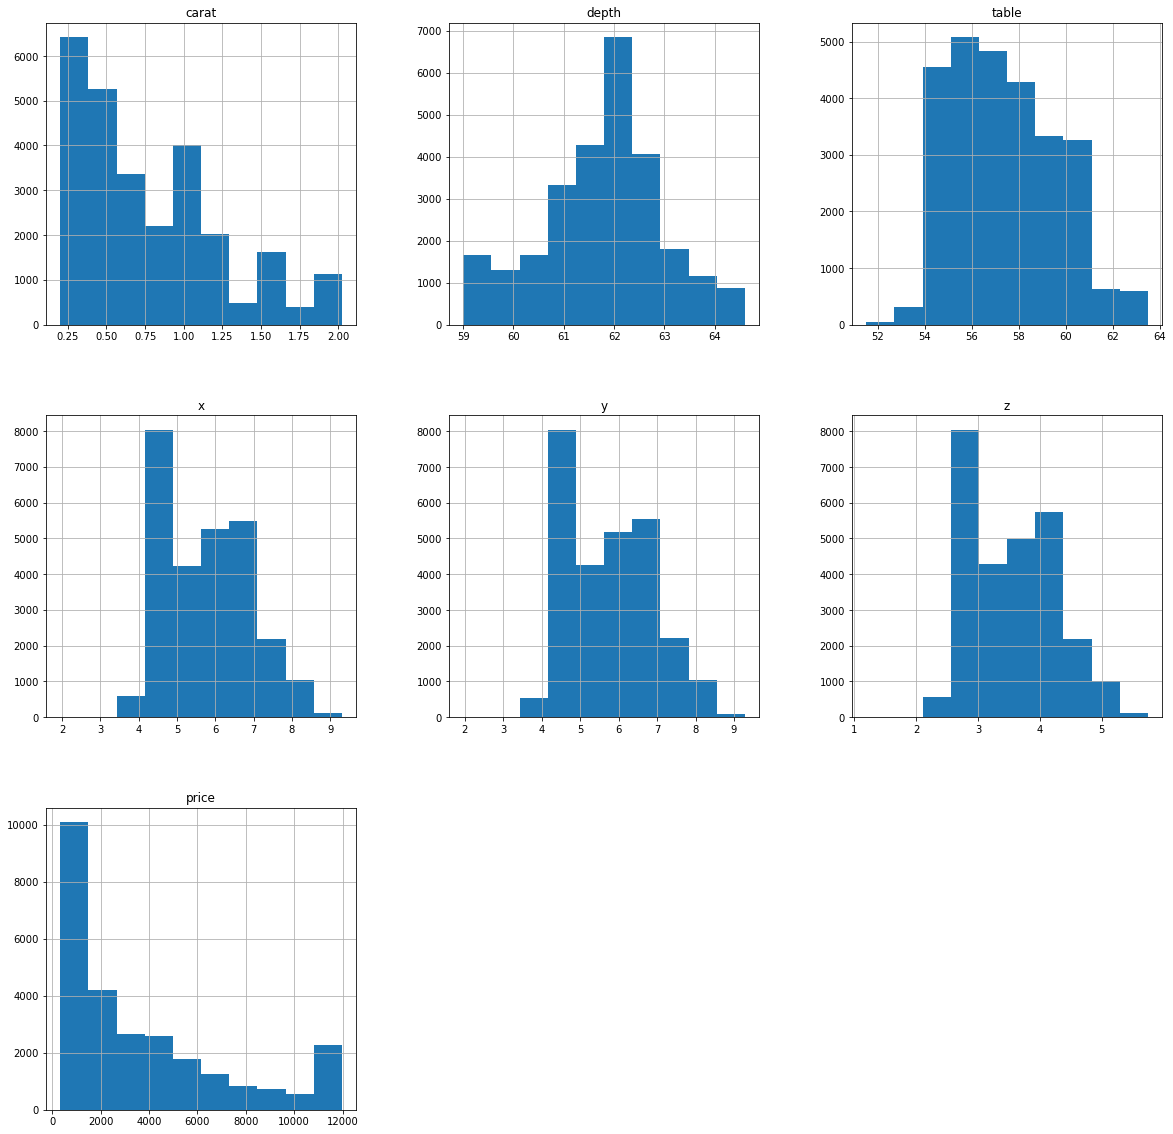

In [28]:
data.hist(figsize=(20,20))

Presence of outliers in the dataset we can see that carot and the price values are heavily right skewed.

# pairplot

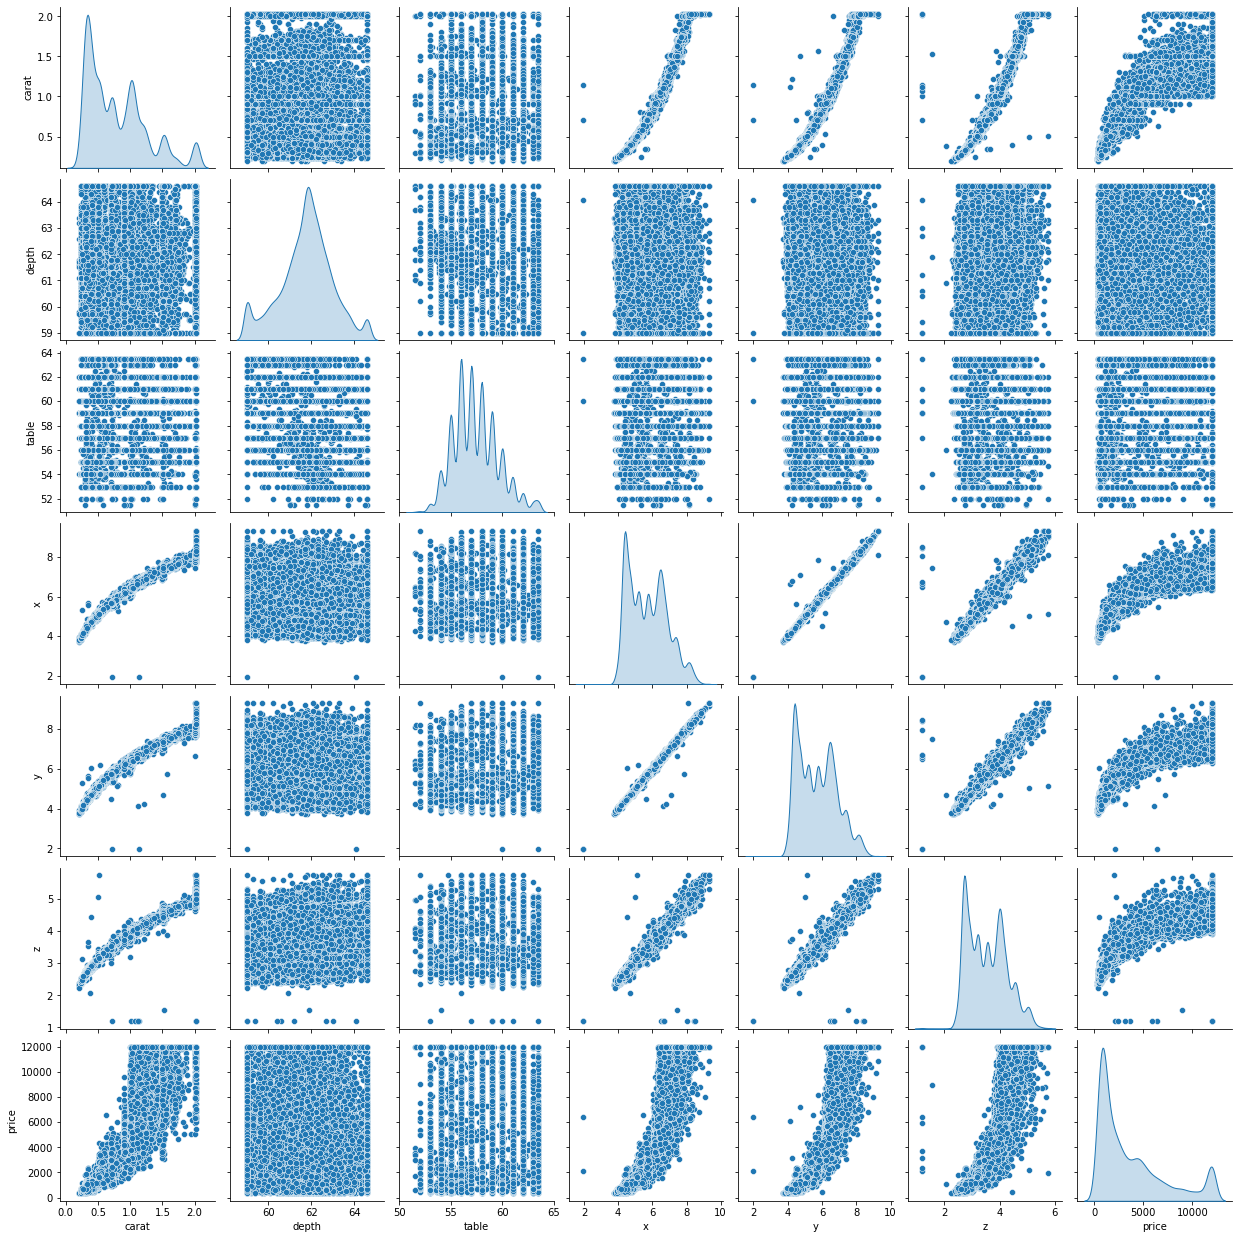

In [29]:
sns.pairplot(data,diag_kind = 'kde')

# Categorical feature analysis

In [30]:
categorical_features

['cut', 'color', 'clarity']

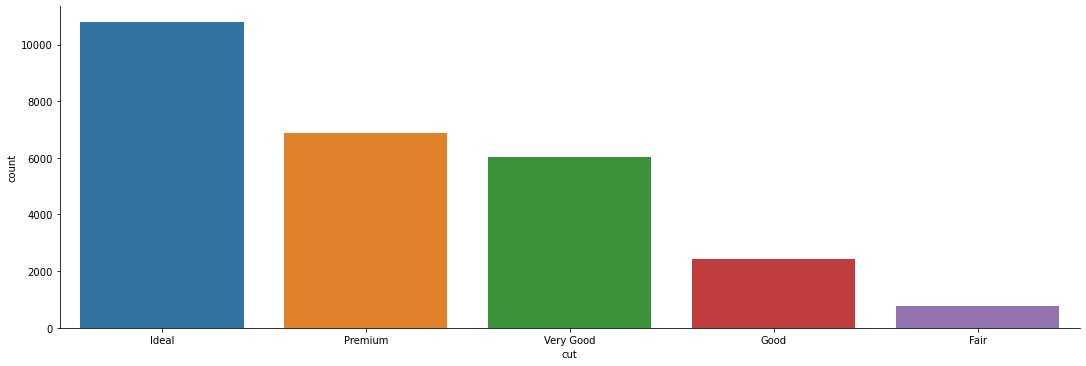

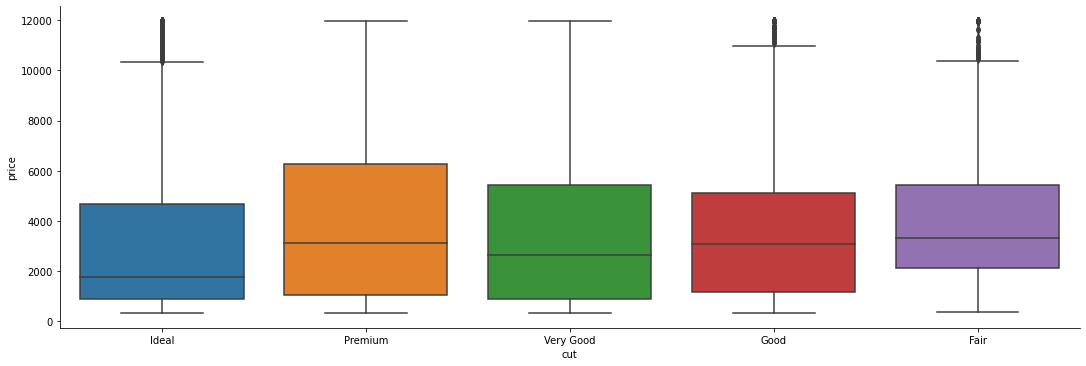

In [31]:
sns.catplot('cut',data = data,kind = 'count',aspect = 3)
sns.catplot(x = 'cut',y = 'price',kind = 'box',data = data,aspect = 3)

Here the Premium cut diamonds are has high value followed very good cut.

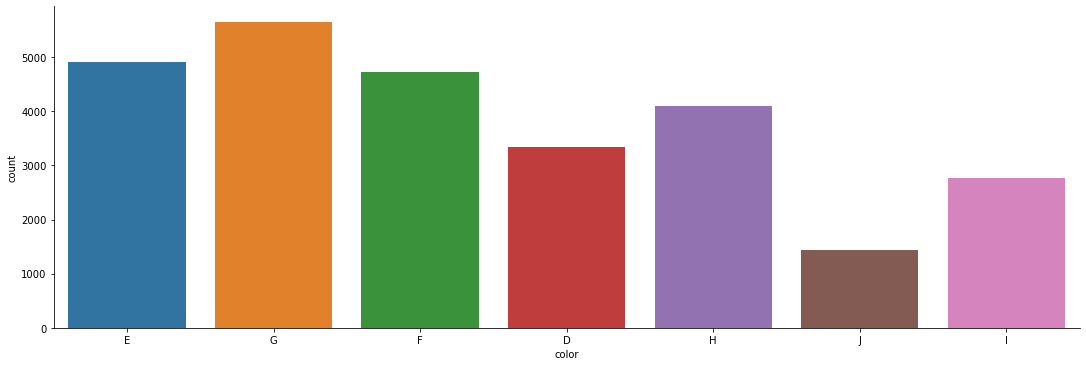

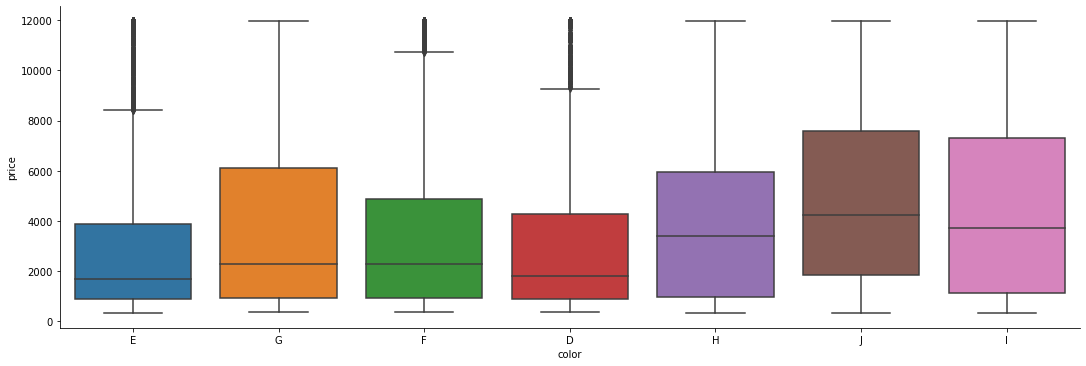

In [32]:
sns.catplot('color',data = data,kind = 'count',aspect = 3)
sns.catplot(x = 'color',y = 'price',kind = 'box',data = data,aspect = 3)

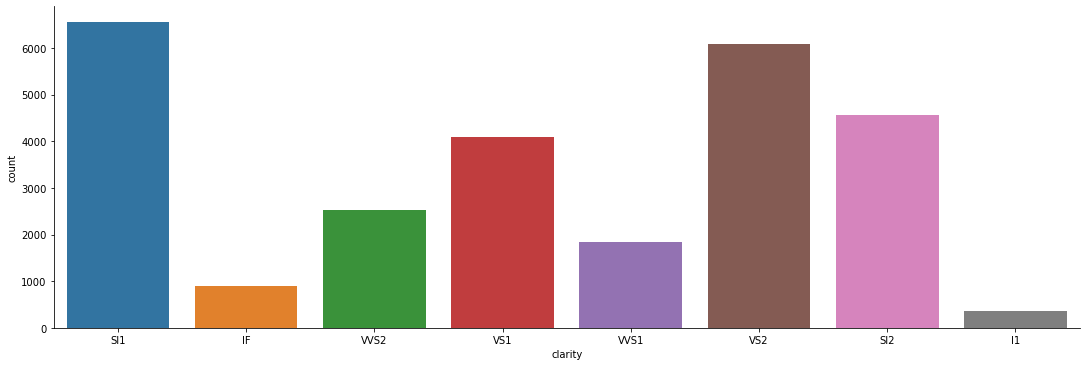

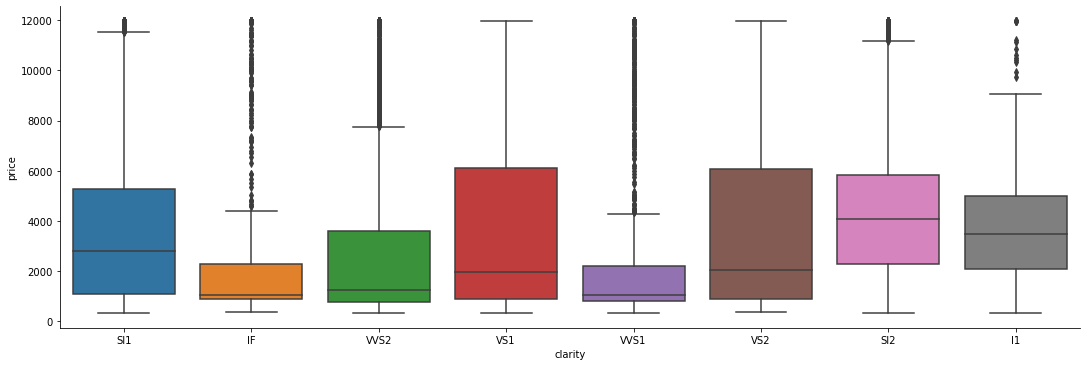

In [33]:
sns.catplot('clarity',data = data,kind = 'count',aspect = 3)
sns.catplot(x = 'clarity',y = 'price',kind = 'box',aspect = 3,data = data)

The diamond Clarity with VS1 & VS2 are the most expensive.

In [34]:
for i in categorical_features:
    print('\n----------------------')
    print(data[i].value_counts())
    


----------------------
Ideal        10805
Premium       6886
Very Good     6027
Good          2435
Fair           780
Name: cut, dtype: int64

----------------------
G    5653
E    4916
F    4723
H    4095
D    3341
I    2765
J    1440
Name: color, dtype: int64

----------------------
SI1     6565
VS2     6093
SI2     4564
VS1     4087
VVS2    2530
VVS1    1839
IF       891
I1       364
Name: clarity, dtype: int64


# EDA Observations:
    1.Price is the target variable.
    2.dataset shape is 26967 rows and 11 columns 
    3.we have 3 categoical and 7 Numerical type column
    4. unnamed: 0 is the only serial no we can drop the column for further analysis
    5. The mean,median, mode values are not much difference.
    6.x,y,z min values are zero. it dimensionless and 2D dimentions are not exits. faulty values are there.
    7.we have 697 observed missing values in the depth.missing values are replaced with the median values.
    8.Dataset has the duplicate values.duplicate values are dropped to further analysis.
    9.There is significant outliers are present in the dataset. we need to treat the outliers for the regression model.
    10.carat and price are heavily right skewed.
    11.The premium cut diamonds are very high in price and followed by very good cut.

# Categorical conversion

In [36]:
data['cut']=np.where(data['cut'] =='Ideal', '4', data['cut'])
data['cut']=np.where(data['cut'] =='Premium', '3', data['cut'])
data['cut']=np.where(data['cut'] =='Very Good', '2', data['cut'])
data['cut']=np.where(data['cut'] =='Good', '1', data['cut'])
data['cut']=np.where(data['cut'] =='Fair', '0', data['cut'])

In [37]:
data['color']=np.where(data['color'] =='D', '6', data['color'])
data['color']=np.where(data['color'] =='E', '5', data['color'])
data['color']=np.where(data['color'] =='F', '4', data['color'])
data['color']=np.where(data['color'] =='G', '3', data['color'])
data['color']=np.where(data['color'] =='H', '2', data['color'])
data['color']=np.where(data['color'] =='I', '1', data['color'])
data['color']=np.where(data['color'] =='J', '0', data['color'])

In [38]:
data['clarity']=np.where(data['clarity'] =='IF', '7', data['clarity'])
data['clarity']=np.where(data['clarity'] =='VVS1', '6', data['clarity'])
data['clarity']=np.where(data['clarity'] =='VVS2', '5', data['clarity'])
data['clarity']=np.where(data['clarity'] =='VS1', '4', data['clarity'])
data['clarity']=np.where(data['clarity'] =='VS2', '3', data['clarity'])
data['clarity']=np.where(data['clarity'] =='SI1', '2', data['clarity'])
data['clarity']=np.where(data['clarity'] =='SI2', '1', data['clarity'])
data['clarity']=np.where(data['clarity'] =='I1', '0', data['clarity'])

In [39]:
data.dtypes

carat      float64
cut         object
color       object
clarity     object
depth      float64
table      float64
x          float64
y          float64
z          float64
price      float64
dtype: object

In [40]:
data['cut'] = data['cut'].astype('float64')
data['color'] = data['color'].astype('float64')
data['clarity'] = data['clarity'].astype('float64')

In [41]:
data.dtypes

carat      float64
cut        float64
color      float64
clarity    float64
depth      float64
table      float64
x          float64
y          float64
z          float64
price      float64
dtype: object

In [42]:
data.head()

,carat,cut,color,clarity,depth,table,x,y,z,price
0,0.30,4.0,5.0,2.0,62.1,58.0,4.27,4.29,2.66,499.0
1,0.33,3.0,3.0,7.0,60.8,58.0,4.42,4.46,2.70,984.0
2,0.90,2.0,5.0,5.0,62.2,60.0,6.04,6.12,3.78,6289.0
3,0.42,4.0,4.0,4.0,61.6,56.0,4.82,4.80,2.96,1082.0
4,0.31,4.0,4.0,6.0,60.4,59.0,4.35,4.43,2.65,779.0


# Train_test_split

In [43]:
x = data.drop('price',axis = 1)
y = data[['price']]

In [44]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.30,random_state = 0)

In [45]:
x_train.shape,y_train.shape

((18853, 9), (18853, 1))

# LinearRegression model 

In [46]:
model = LinearRegression()
model.fit(x_train,y_train)

LinearRegression()

In [47]:
for idx, col_name in enumerate(x_train.columns):
    print('The coefficient for {} is {}'.format(col_name,model.coef_[0][idx]))

The coefficient for carat is 8732.244381156272
The coefficient for cut is 102.63446742924343
The coefficient for color is 274.6741836281721
The coefficient for clarity is 433.75172613676557
The coefficient for depth is -5.047780737495458
The coefficient for table is -12.080882342638407
The coefficient for x is -1376.3763305148918
The coefficient for y is 1299.0708787169551
The coefficient for z is -414.05067037643937


See the every one unit change in positive displacement we can see that carat,cut,color,clarity,y column has the positive correaltion in the displacement.
And depth,x,z is negative displacement

In [48]:
intercept =  model.intercept_[0]
print('The intercept for our model is ',intercept)

The intercept for our model is  -2842.003117878334


The intercept score of our model is -2842.003 is meaning less we can do zscale to reduce the value zero.

# Stats model liberary to get r type outputs

In [49]:
data_train = pd.concat([x_train,y_train],axis = 1)
data_train.head()

,carat,cut,color,clarity,depth,table,x,y,z,price
8747,1.19,4.0,5.0,1.0,60.2,57.0,6.84,6.87,4.13,5717.0
13821,0.36,4.0,6.0,3.0,61.0,56.0,4.63,4.59,2.81,1094.0
13582,1.20,1.0,1.0,2.0,63.1,58.0,6.66,6.72,4.22,4752.0
9952,0.24,2.0,5.0,6.0,60.7,60.0,4.01,4.06,2.45,485.0
25530,0.50,2.0,4.0,5.0,61.8,56.0,5.11,5.15,3.17,2052.0


In [50]:
lm1 = smf.ols(formula = 'price~carat+cut+color+clarity+depth+table+x+y+z',data = data_train).fit()
lm1.params  #// coeffients

Intercept   -2842.003118
carat        8732.244381
cut           102.634467
color         274.674184
clarity       433.751726
depth          -5.047781
table         -12.080882
x           -1376.376331
y            1299.070879
z            -414.050670
dtype: float64

In [51]:
print(lm1.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.931
Model:                            OLS   Adj. R-squared:                  0.931
Method:                 Least Squares   F-statistic:                 2.816e+04
Date:                Fri, 22 Apr 2022   Prob (F-statistic):               0.00
Time:                        20:51:34   Log-Likelihood:            -1.5523e+05
No. Observations:               18853   AIC:                         3.105e+05
Df Residuals:                   18843   BIC:                         3.106e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -2842.0031    717.059     -3.963      0.0

# Observations:
    1.adj R.Squared values are equal to the R-squared value.
    2.Here we can see the p-value is less than the depth column. so we can drop the column. its useless.

# Check the Sum of squared errors

In [52]:
#RMSE on Test data
mse = np.mean((model.predict(x_test)-y_test)**2)
math.sqrt(mse)

907.024328870826

In [53]:
#RMSE on Train data
mse1 = np.mean((model.predict(x_train)-y_train)**2)
math.sqrt(mse1)

911.0173665565054

# Train and Test Score

In [54]:
score = model.score(x_train,y_train)
print('The model score is',score)

The model score is 0.930790594674339


In [55]:
score1 = model.score(x_test,y_test)
print('The model score is',score1)

The model score is 0.9320775031524997


Here we can got train and test set value of 93% so we are in right fit zone.

In [57]:
model.score(x_test,y_test)

0.9320775031524997

In [58]:
#predicting the price value for test datset
y_pred = model.predict(x_test)

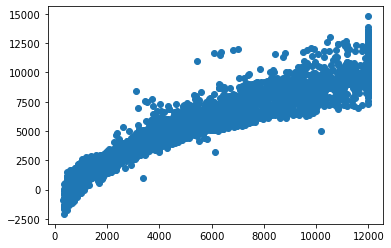

In [59]:
# actual y value and the predicted y value 
plt.scatter(y_test['price'],y_pred)

Here we can see that linear relationship between the actual values and the predicted values. And we can see that lot of spread over the data points in the data. There are some unexplained variance in the output.

In [61]:
x_train_scaled = x_train.apply(zscore)
y_train_scaled = y_train.apply(zscore)
x_test_scaled = x_test.apply(zscore)
y_test_scaled = y_test.apply(zscore)

In [62]:
scaled_model = LinearRegression()
scaled_model.fit(x_train_scaled,y_train_scaled)

LinearRegression()

In [63]:
#coeffient for each of the attributes
for idx,col_name in enumerate(x_train.columns):
    print('The coefficient for {} is {}'.format(col_name,scaled_model.coef_[0][idx]))

The coefficient for carat is 1.1662216647651826
The coefficient for cut is 0.033014286987267306
The coefficient for color is 0.13484378150192636
The coefficient for clarity is 0.2064904591805565
The coefficient for depth is -0.001780541741662929
The coefficient for table is -0.00752394606449265
The coefficient for x is -0.44760762292654205
The coefficient for y is 0.41918644487832657
The coefficient for z is -0.08329652906420305


In [64]:
scaled_intercept = scaled_model.intercept_[0]
print('The intercept of our model',scaled_intercept)

The intercept of our model -2.0241701799285394e-17


After applying the zscore the intercept become -2.0241 e^-17. The bias become nearly zero but the overall accuracy still same.

In [65]:
scaled_model.score(x_test_scaled,y_test_scaled)

0.9321343672254273

# Mean Squred Errors:

In [66]:
mse_test = np.mean((scaled_model.predict(x_test_scaled)-y_test_scaled)**2)
math.sqrt(mse_test)

0.2605103314161894

In [67]:
mse_train = np.mean((scaled_model.predict(x_train_scaled)-y_train_scaled)**2)
math.sqrt(mse_train)

0.26307680499363895

In [68]:
y_predict = scaled_model.predict(x_test_scaled)

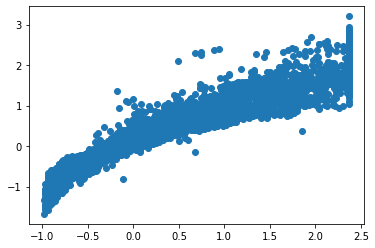

In [69]:
plt.scatter(y_test_scaled['price'],y_predict)

# Scalling:
scalling the dataset does not affect the accuracy of the model and its remove the intercept value of the model and it change the coeffient of the columns.

# variance inflation factor

To check the muilitcollinearity 

In [70]:
vif = [variance_inflation_factor(x.values,ix) for ix in range (x.shape[1])]

In [71]:
i = 0
for column in x.columns:
    if i<11:
        print(column ,"--->",vif[i])
        i = i+1

carat ---> 113.0417239964068
cut ---> 9.740611213137626
color ---> 5.543455746143866
clarity ---> 5.423376502060876
depth ---> 956.9672022267032
table ---> 756.8970095642792
x ---> 10286.70533742764
y ---> 9325.510023661736
z ---> 1981.5080683696413


We can see that very strong multi collinearity are present here.

In [73]:
for i,j in np.array(lm1.params.reset_index()):
    print('({}) * {} +'.format(round(j,2),i),end=' ')

(-2842.0) * Intercept + (8732.24) * carat + (102.63) * cut + (274.67) * color + (433.75) * clarity + (-5.05) * depth + (-12.08) * table + (-1376.38) * x + (1299.07) * y + (-414.05) * z + 

# Insights:
    1. When carat increases by 1 unit, diamond price increases by 8732.44 units, keeping all other predictors constant.
    2. When cut increases by 1 unit, diamond price increases by 102.63 units, keeping all other predictors constant.
    3. When color increases by 1 unit, diamond price increases by 274.67 units, keeping all other predictors constant.
    3. When clarity increases by 1 unit, diamond price increases by 433.75 units, keeping all other predictors constant.
    4. When y increases by 1 unit, diamond price increases by 1299.07 units, keeping all other predictors constant.

The column of X,Z,table are inversly propotional with diamond price.
So as per the model the most important attributes are :
    1.carat
    2.cut
    3.color
    4.clarity
    5.y